# Grafana Logs - Data Preprocessing

This notebook performs preprocessing on Grafana logs from `ml_training_data.jsonl`.

## Key Issues with Grafana Logs:
1. **Mixed units**: Different panels use different units (percent, seconds, milliseconds, count)
2. **Different value ranges**: Metrics have vastly different scales
3. **Time-series nature**: Temporal patterns are important
4. **Categorical variables**: Need proper encoding
5. **Missing values**: Some fields like anomaly_type are null
6. **Class imbalance**: Likely more normal logs than anomalies

## Preprocessing Steps:
1. Load and explore the data
2. Handle missing values
3. Parse timestamps and extract temporal features
4. Normalize/scale numeric values per unit type
5. Handle categorical variables
6. Save preprocessed data

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore Data

In [2]:
# # Load JSONL data
# data_path = '../../synthetic-log-generator/output/grafana/ml_training_data.jsonl'

# logs = []
# with open(data_path, 'r') as f:
#     for line in f:
#         logs.append(json.loads(line.strip()))

# df = pd.DataFrame(logs)
# print(f"Loaded {len(df)} log entries")
# print(f"\nDataset shape: {df.shape}")
# print(f"\nColumn names: {df.columns.tolist()}")
import json
import pandas as pd

# Load JSONL data
data_path = '../../synthetic-log-generator/output/grafana/ml_training_data.jsonl'

logs = []

with open(data_path, 'r') as f:
    for i, line in enumerate(f, start=1):
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
        
        try:
            logs.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipping invalid JSON at line {i}: {e}")
            continue

df = pd.DataFrame(logs)

print(f"Loaded {len(df)} log entries")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")


Skipping invalid JSON at line 1: Expecting value: line 1 column 1 (char 0)
Loaded 149999 log entries

Dataset shape: (149999, 14)

Column names: ['timestamp', 'unix_timestamp', 'dashboard', 'panel', 'service', 'value', 'unit', 'environment', 'cluster', 'datasource', 'is_anomaly', 'anomaly_type', 'query', 'metadata']


In [3]:
# Display first few rows
df.head()

,timestamp,unix_timestamp,dashboard,panel,service,value,unit,environment,cluster,datasource,is_anomaly,anomaly_type,query,metadata
0,2024-01-01T00:00:26,1704047426,Database Metrics,Connection Pool Usage,api-gateway,32.39,percent,production,production-us-east-1,Prometheus,False,None,"pgbouncer_pools_cl_active{database=""api-gatewa...","{'panel_type': 'gauge', 'visualization': 'gauge'}"
1,2024-01-01T00:00:33,1704047433,Infrastructure Overview,Memory Usage,product-service,41.51,percent,production,production-us-east-1,Prometheus,False,None,"container_memory_usage_bytes{pod=~""product-ser...","{'panel_type': 'gauge', 'visualization': 'graph'}"
2,2024-01-01T00:00:46,1704047446,Cache Performance,Cache Hit Rate,api-gateway,89.10,percent,production,production-us-east-1,Prometheus,False,None,redis_keyspace_hits_total / (redis_keyspace_hi...,"{'panel_type': 'graph', 'visualization': 'graph'}"
3,2024-01-01T00:01:07,1704047467,JVM Metrics,GC Time,analytics-service,0.04,seconds,production,production-us-east-1,Prometheus,False,None,"rate(jvm_gc_collection_seconds_sum{service=""an...","{'panel_type': 'graph', 'visualization': 'graph'}"
4,2024-01-01T00:01:10,1704047470,Infrastructure Overview,Memory Usage,product-service,34.13,percent,production,production-us-east-1,Prometheus,False,None,"container_memory_usage_bytes{pod=~""product-ser...","{'panel_type': 'gauge', 'visualization': 'graph'}"


In [4]:
# Basic statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149999 entries, 0 to 149998
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       149999 non-null  object 
 1   unix_timestamp  149999 non-null  int64  
 2   dashboard       149999 non-null  object 
 3   panel           149999 non-null  object 
 4   service         149999 non-null  object 
 5   value           149999 non-null  float64
 6   unit            149999 non-null  object 
 7   environment     149999 non-null  object 
 8   cluster         149999 non-null  object 
 9   datasource      149999 non-null  object 
 10  is_anomaly      149999 non-null  bool   
 11  anomaly_type    30000 non-null   object 
 12  query           149999 non-null  object 
 13  metadata        149999 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 15.0+ MB


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])
print(f"\nTotal missing values: {missing_values.sum()}")

Missing values per column:
anomaly_type    119999
dtype: int64

Total missing values: 119999


In [6]:
# Explore categorical columns
categorical_cols = ['dashboard', 'panel', 'service', 'unit', 'environment', 'cluster', 'datasource']

for col in categorical_cols:
    print(f"\n{col.upper()}:")
    print(f"Unique values: {df[col].nunique()}")
    print(df[col].value_counts().head(10))


DASHBOARD:
Unique values: 5
dashboard
Application Performance    48066
Infrastructure Overview    37506
JVM Metrics                25670
Database Metrics           25042
Cache Performance          13715
Name: count, dtype: int64

PANEL:
Unique values: 12
panel
Error Rate               13854
CPU Usage                13849
Connection Pool Usage    13818
GC Time                  13770
Cache Hit Rate           13715
JVM Heap Usage           11900
Network Traffic          11887
Request Rate             11826
Memory Usage             11770
Response Time P99        11284
Name: count, dtype: int64

SERVICE:
Unique values: 7
service
analytics-service       21665
notification-service    21546
product-service         21484
api-gateway             21417
order-service           21371
user-service            21302
payment-service         21214
Name: count, dtype: int64

UNIT:
Unique values: 5
unit
percent    78906
ms         33610
seconds    13770
MB/s       11887
req/s      11826
Name: count, dtyp

In [7]:
# Check anomaly distribution
print("Anomaly Distribution:")
print(df['is_anomaly'].value_counts())
print(f"\nAnomaly percentage: {df['is_anomaly'].mean() * 100:.2f}%")

if 'anomaly_type' in df.columns:
    print("\nAnomaly Types:")
    print(df[df['is_anomaly'] == True]['anomaly_type'].value_counts())

Anomaly Distribution:
is_anomaly
False    119999
True      30000
Name: count, dtype: int64

Anomaly percentage: 20.00%

Anomaly Types:
anomaly_type
connection_pool_exhaustion    3805
cache_miss_spike              3793
high_error_rate               3786
gc_pressure                   3766
traffic_spike                 3742
slow_response                 3718
cpu_spike                     3713
memory_spike                  3677
Name: count, dtype: int64


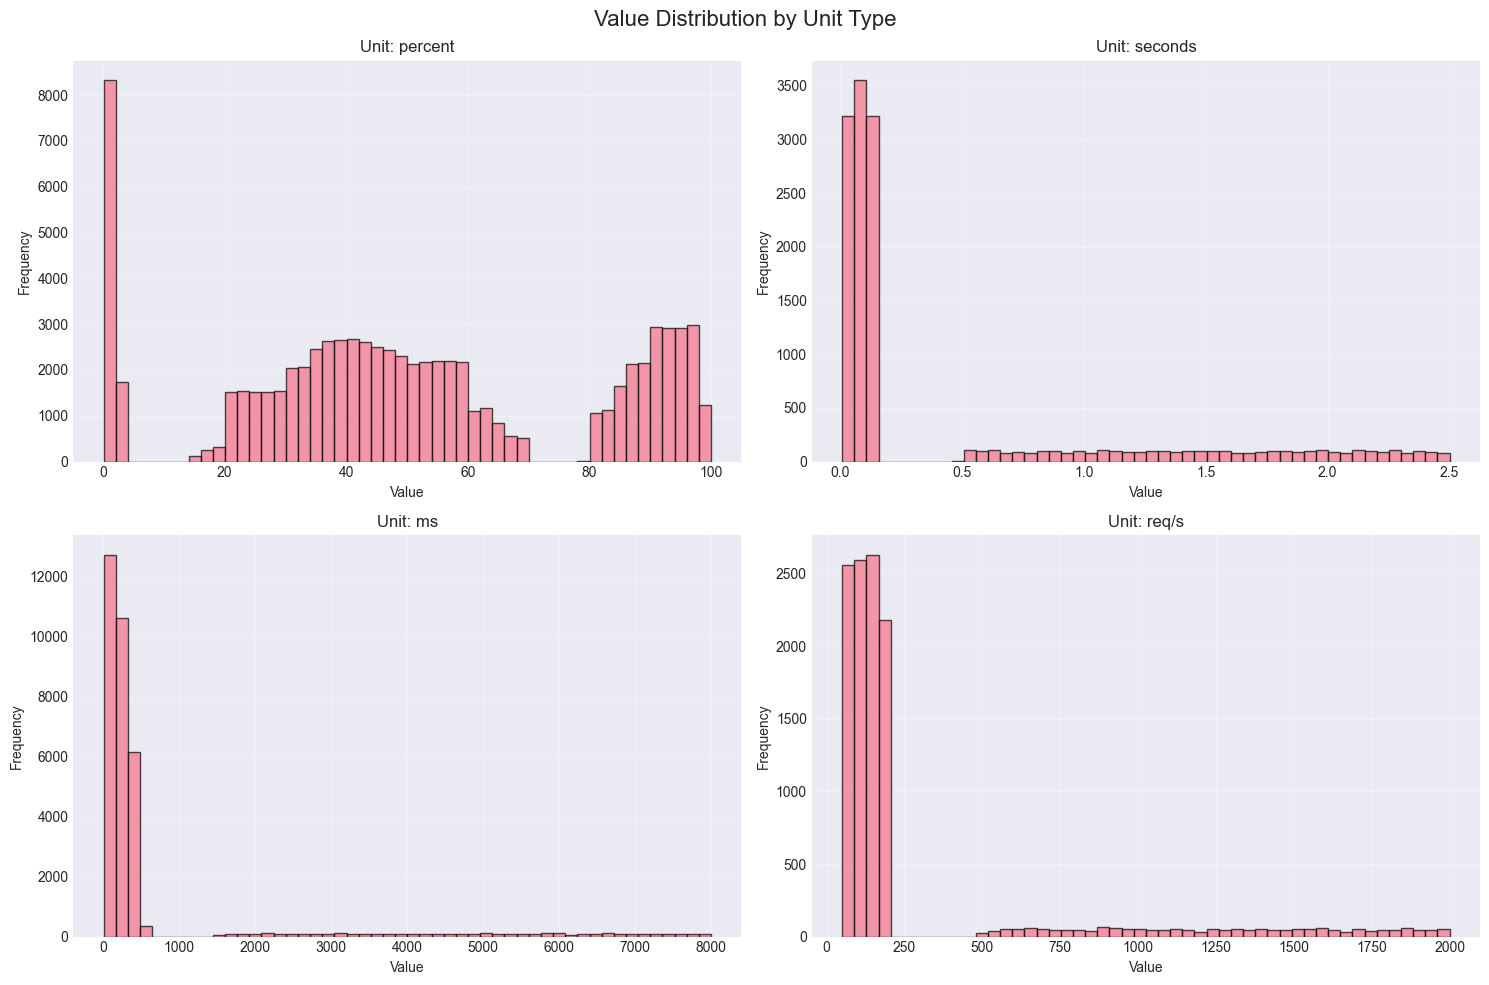

In [8]:
# Visualize value distribution by unit
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Value Distribution by Unit Type', fontsize=16)

units = df['unit'].unique()[:4]
for idx, unit in enumerate(units):
    ax = axes[idx // 2, idx % 2]
    unit_data = df[df['unit'] == unit]['value']
    ax.hist(unit_data, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'Unit: {unit}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Handle Missing Values

In [9]:
# Create a copy for preprocessing
df_processed = df.copy()

# Fill anomaly_type with 'normal' for non-anomalies
df_processed['anomaly_type'] = df_processed['anomaly_type'].fillna('normal')

# Check if metadata needs unpacking
if 'metadata' in df_processed.columns:
    # Extract metadata fields
    df_processed['panel_type'] = df_processed['metadata'].apply(lambda x: x.get('panel_type', 'unknown') if isinstance(x, dict) else 'unknown')
    df_processed['visualization'] = df_processed['metadata'].apply(lambda x: x.get('visualization', 'unknown') if isinstance(x, dict) else 'unknown')
    df_processed = df_processed.drop('metadata', axis=1)

print("Missing values handled!")
print(f"\nRemaining missing values: {df_processed.isnull().sum().sum()}")

Missing values handled!

Remaining missing values: 0


## 3. Parse Timestamps and Extract Temporal Features

In [10]:
# Convert timestamp to datetime
df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])

# Extract temporal features
df_processed['hour'] = df_processed['timestamp'].dt.hour
df_processed['day_of_week'] = df_processed['timestamp'].dt.dayofweek
df_processed['day_of_month'] = df_processed['timestamp'].dt.day
df_processed['is_weekend'] = df_processed['day_of_week'].isin([5, 6]).astype(int)
df_processed['is_business_hours'] = df_processed['hour'].between(9, 17).astype(int)

# Time since start (in hours)
df_processed['hours_since_start'] = (df_processed['timestamp'] - df_processed['timestamp'].min()).dt.total_seconds() / 3600

print("Temporal features extracted:")
print(df_processed[['timestamp', 'hour', 'day_of_week', 'is_weekend', 'is_business_hours']].head())

Temporal features extracted:
            timestamp  hour  day_of_week  is_weekend  is_business_hours
0 2024-01-01 00:00:26     0            0           0                  0
1 2024-01-01 00:00:33     0            0           0                  0
2 2024-01-01 00:00:46     0            0           0                  0
3 2024-01-01 00:01:07     0            0           0                  0
4 2024-01-01 00:01:10     0            0           0                  0


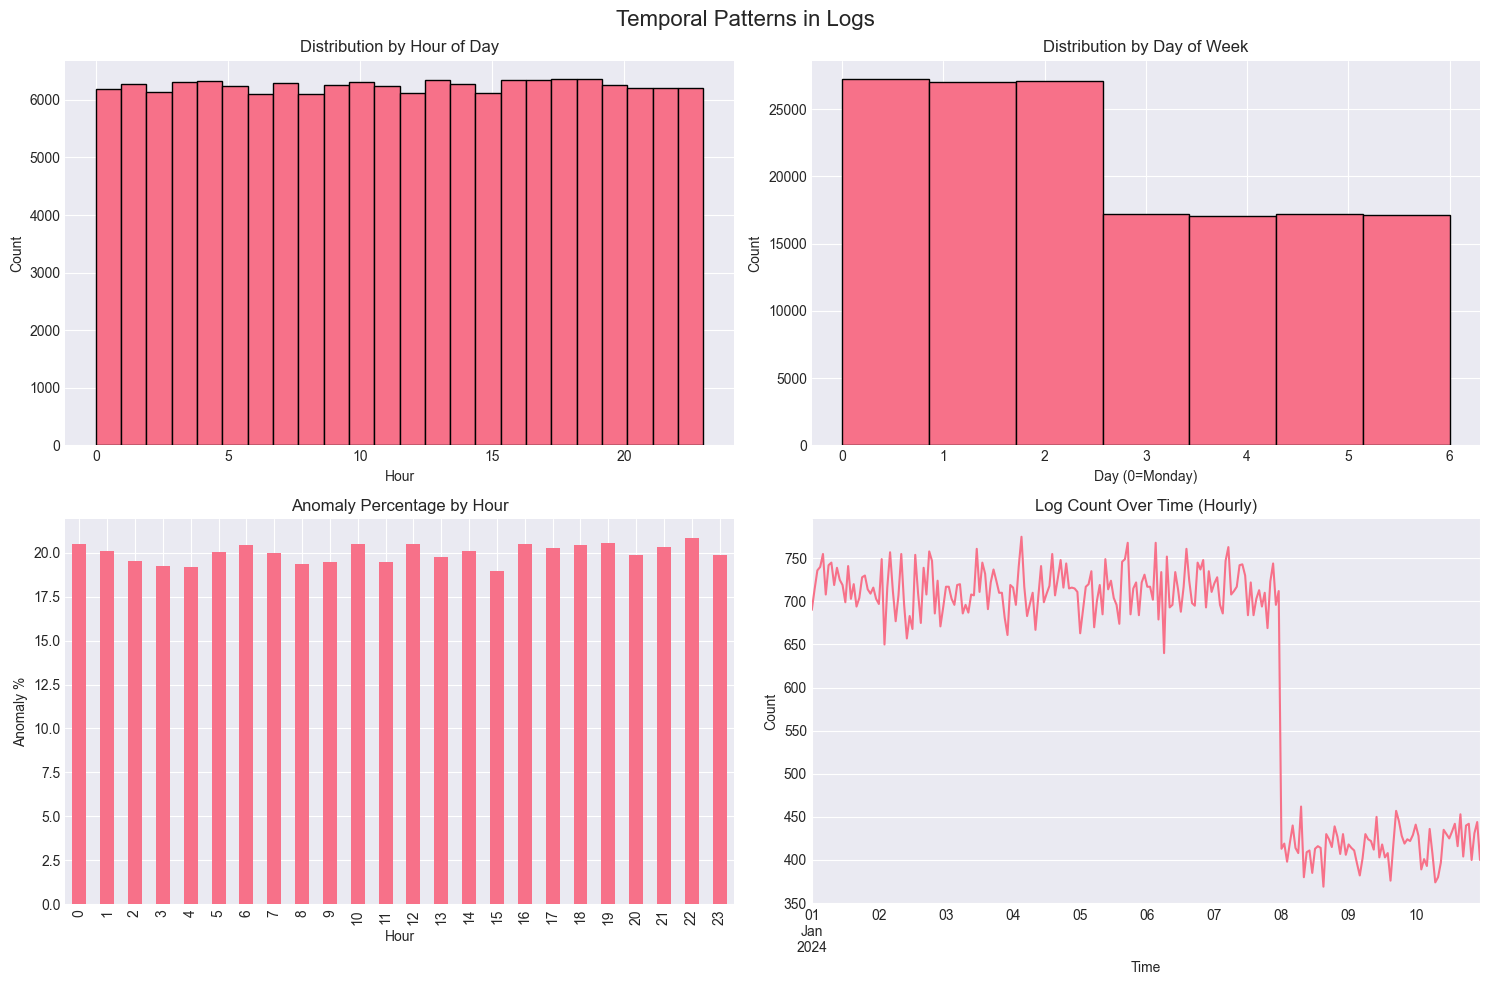

In [11]:
# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Temporal Patterns in Logs', fontsize=16)

# Hour distribution
df_processed['hour'].hist(bins=24, ax=axes[0, 0], edgecolor='black')
axes[0, 0].set_title('Distribution by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Count')

# Day of week distribution
df_processed['day_of_week'].hist(bins=7, ax=axes[0, 1], edgecolor='black')
axes[0, 1].set_title('Distribution by Day of Week')
axes[0, 1].set_xlabel('Day (0=Monday)')
axes[0, 1].set_ylabel('Count')

# Anomaly by hour
anomaly_by_hour = df_processed.groupby('hour')['is_anomaly'].mean() * 100
anomaly_by_hour.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Anomaly Percentage by Hour')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Anomaly %')

# Time series of logs
df_processed.set_index('timestamp')['value'].resample('1H').count().plot(ax=axes[1, 1])
axes[1, 1].set_title('Log Count Over Time (Hourly)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 4. Normalize/Scale Numeric Values

Critical: Different units have different scales. We'll normalize within unit types.

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize values within each unit type using StandardScaler
df_processed['value_normalized'] = 0.0

for unit in df_processed['unit'].unique():
    mask = df_processed['unit'] == unit
    values = df_processed.loc[mask, 'value'].values.reshape(-1, 1)
    
    scaler = StandardScaler()
    normalized_values = scaler.fit_transform(values).flatten()
    
    df_processed.loc[mask, 'value_normalized'] = normalized_values

print("Value normalization completed!")
print(f"\nOriginal value stats:")
print(df_processed['value'].describe())
print(f"\nNormalized value stats:")
print(df_processed['value_normalized'].describe())

Value normalization completed!

Original value stats:
count    149999.000000
mean        228.144037
std         803.999603
min           0.010000
25%          30.200000
50%          55.980000
75%          96.860000
max        7997.450000
Name: value, dtype: float64

Normalized value stats:
count    1.499990e+05
mean    -6.669672e-17
std      1.000003e+00
min     -1.694704e+00
25%     -4.815766e-01
50%     -3.109240e-01
75%      2.784331e-01
max      4.697158e+00
Name: value_normalized, dtype: float64


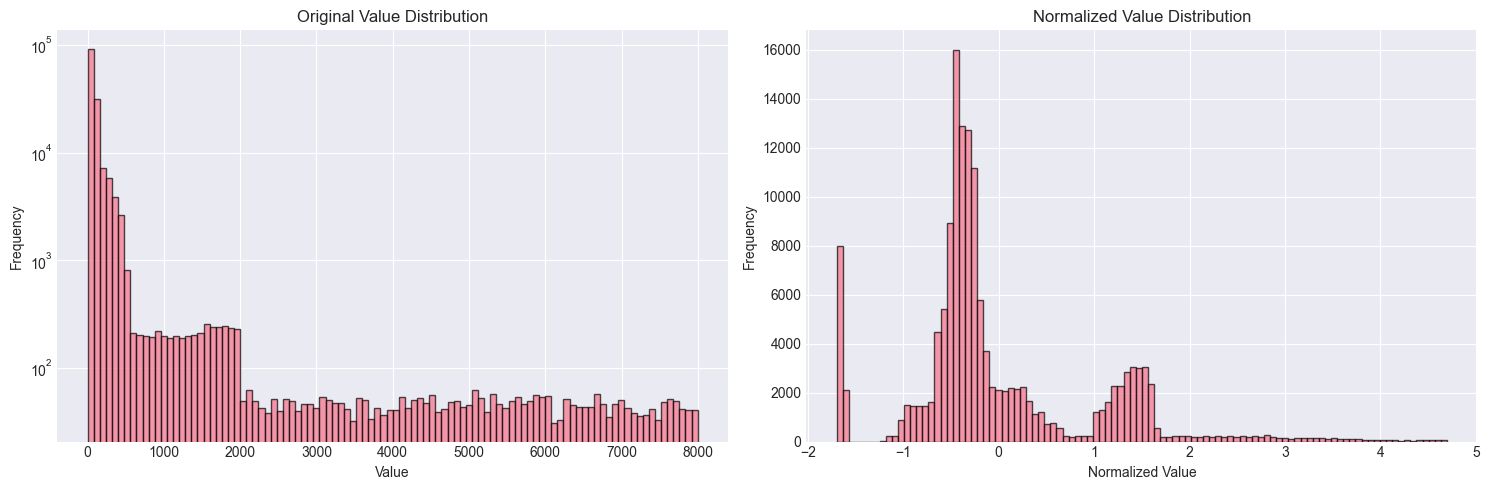

In [13]:
# Compare original vs normalized values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_processed['value'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Original Value Distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

axes[1].hist(df_processed['value_normalized'], bins=100, edgecolor='black', alpha=0.7)
axes[1].set_title('Normalized Value Distribution')
axes[1].set_xlabel('Normalized Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Create Statistical Features

For time-series data, rolling statistics can be very informative.

In [14]:
# Sort by timestamp for rolling calculations
df_processed = df_processed.sort_values('timestamp').reset_index(drop=True)

# Calculate rolling statistics per service-panel combination
window_size = 10  # 10 consecutive measurements

df_processed['value_rolling_mean'] = df_processed.groupby(['service', 'panel'])['value_normalized'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

df_processed['value_rolling_std'] = df_processed.groupby(['service', 'panel'])['value_normalized'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).std().fillna(0)
)

df_processed['value_rolling_min'] = df_processed.groupby(['service', 'panel'])['value_normalized'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).min()
)

df_processed['value_rolling_max'] = df_processed.groupby(['service', 'panel'])['value_normalized'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).max()
)

# Deviation from rolling mean
df_processed['value_deviation'] = df_processed['value_normalized'] - df_processed['value_rolling_mean']

print("Statistical features created!")
print(df_processed[['value_normalized', 'value_rolling_mean', 'value_rolling_std', 'value_deviation']].head(15))

Statistical features created!
    value_normalized  value_rolling_mean  value_rolling_std  value_deviation
0          -0.610049           -0.610049           0.000000         0.000000
1          -0.303699           -0.303699           0.000000         0.000000
2           1.294897            1.294897           0.000000         0.000000
3          -0.609923           -0.609923           0.000000         0.000000
4          -0.551601           -0.427650           0.175293        -0.123951
5          -0.437534           -0.437534           0.000000         0.000000
6          -0.320479           -0.320479           0.000000         0.000000
7           0.244170            0.244170           0.000000         0.000000
8          -0.091740           -0.091740           0.000000         0.000000
9          -1.675221           -1.675221           0.000000         0.000000
10         -0.730977           -0.730977           0.000000         0.000000
11          0.147428            0.147428      

## 6. Save Preprocessed Data

In [15]:
# Save preprocessed data
output_path = '../data/grafana_logs_preprocessed.csv'
df_processed.to_csv(output_path, index=False)
print(f"Preprocessed data saved to: {output_path}")
print(f"Shape: {df_processed.shape}")
print(f"\nColumns: {df_processed.columns.tolist()}")

Preprocessed data saved to: ../data/grafana_logs_preprocessed.csv
Shape: (149999, 27)

Columns: ['timestamp', 'unix_timestamp', 'dashboard', 'panel', 'service', 'value', 'unit', 'environment', 'cluster', 'datasource', 'is_anomaly', 'anomaly_type', 'query', 'panel_type', 'visualization', 'hour', 'day_of_week', 'day_of_month', 'is_weekend', 'is_business_hours', 'hours_since_start', 'value_normalized', 'value_rolling_mean', 'value_rolling_std', 'value_rolling_min', 'value_rolling_max', 'value_deviation']


In [16]:
# Summary statistics
print("=" * 80)
print("PREPROCESSING SUMMARY")
print("=" * 80)
print(f"Total records: {len(df_processed):,}")
print(f"Date range: {df_processed['timestamp'].min()} to {df_processed['timestamp'].max()}")
print(f"Unique services: {df_processed['service'].nunique()}")
print(f"Unique dashboards: {df_processed['dashboard'].nunique()}")
print(f"Unique panels: {df_processed['panel'].nunique()}")
print(f"Anomaly rate: {df_processed['is_anomaly'].mean() * 100:.2f}%")
print(f"\nFeatures created: {len(df_processed.columns)}")
print("="  * 80)

PREPROCESSING SUMMARY
Total records: 149,999
Date range: 2024-01-01 00:00:26 to 2024-01-10 23:59:55
Unique services: 7
Unique dashboards: 5
Unique panels: 12
Anomaly rate: 20.00%

Features created: 27
